The approach analyzed below is the one currently adopted in fast.ai and that is called [ULMFiT](https://arxiv.org/abs/1801.06146) (Universal Language Model Fine-tuning).<br>
It is strongly based on the concept of transfer learning in particular allowing the training of Language Model on a corpus and the possibility to sharpen the model on different corpus, but starting from what learned in the previous step.
A language model is a model that aims to predict a word given the set of previous words.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%load_ext autoreload
%autoreload 2
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from shutil import copyfile

#Tokenization

We used `get-wikimedia.sh`tool from [fastText](https://github.com/facebookresearch/fastText). This tool allows us to make a dump of the most updated wikipedia italian version and to generate a flat file on which a pre-processing is done automatically to remove Wikipedia tags/metadata etc.

In [ ]:
!/content/drive/My Drive/Colab Notebooks/deepfrench/tools/get-wikimedia.sh
!wc -l /content/drive/My Drive/Colab Notebooks/deepfrench/tools/data/wikimedia/20200527/wiki-it.txt

In [ ]:
PATH = Path('/content/drive/My Drive/Colab Notebooks/deepfrench/tools/data/wikimedia/20200527/')

p_in_tokenizer_language = 'it'
p_in_max_vocab = 60000
p_in_partial_data_pct=.25

base_wikipedia_path = '/storage/Data/NLPData/Wikipedia'
wikipedia_train_file_name = 'train400M.csv'
wikipedia_valid_file_name = 'val400M.csv'
wikipedia_merged_file_name = 'merged400M.csv'
wikipedia_tokenized_pickle_file_name = 'wikipedia_100_tokenized.pkl'
wikipedia_tokenized_itos_pickle_file_name = 'wikipedia_100_tokenized_itos.pkl'

Now we got all the data and we need to format it in a way that the fast.ai library can manage it, splitting it in validation and training sets and building a csv file.

In [ ]:
train = pd.read_csv(PATH/wikipedia_train_file_name, header=None, names=['content'])
valid = pd.read_csv(PATH/wikipedia_valid_file_name, header=None, names=['content'])

train['is_valid'] = False
valid['is_valid'] = True

df_regroup = pd.concat([train, valid])

df_regroup.to_csv(PATH/wikipedia_merged_file_name, header=None, index=None)

Release memory

In [ ]:
del df_regroup
del train
del valid

Here we define a tokenizer for the italian language

In [ ]:
tokenizer = Tokenizer(lang=p_in_tokenizer_language)

Here we load the previously built csv, considering the tokenizer and the vocabulary and configuring a batch_size equal to 128 

In [ ]:
import pandas as pd

data_lm_full = (TextList.from_csv(PATH, csv_name=wikipedia_merged_file_name, cols=0, processor=[TokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(max_vocab=p_in_max_vocab)])
            .use_partial_data(p_in_partial_data_pct, seed=42)
            #Inputs: all the text files in path
            .split_from_df(col=1)
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=128))

In [ ]:
data_lm_full.save(wikipedia_tokenized_pickle_file_name)
pickle.dump( data_lm_full.vocab.itos, open( PATH/wikipedia_tokenized_itos_pickle_file_name, "wb" ) )

#Training
First language model

In [ ]:
p_in_bs=128
PATH = '/content/drive/My Drive/Colab Notebooks/ULMFiT/wikipedia'

wikipedia_tokenized_pickle_file_name = 'wikipedia_100_tokenized.pkl'
wikipedia_tokenized_itos_pickle_file_name = 'wikipedia_100_tokenized_itos.pkl'


Loading of our DataBunch with the creating of our `learner`<br>
The architecture for our NN is **AWD_LSTM**

Then proceed with the classic approach to perform the training/fine-tuning of the model:<br>
`fit_one_cycle + save + lr_find + freeze/unfreeze`

In [ ]:
data_lm_full = load_data(PATH, wikipedia_tokenized_pickle_file_name, bs=p_in_bs)
data_lm_full.show_batch()

In [ ]:
learn = language_model_learner(data_lm_full,AWD_LSTM, pretrained=False,  callback_fns=ShowGraph)

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_start=0)

In [ ]:
learn.fit_one_cycle(10, 3e-2, moms=(0.8,0.7),callbacks=[ShowGraph(learn), SaveModelCallback(learn,monitor='accuracy',mode='max')])

We save the language model obtained and the vocabulary

In [ ]:
learn.save('it-wiki-languagelearner-60k')
pickle.dump( data_lm_full.vocab.itos, open( PATH/”models/itos.pkl”, “wb” ) )

Test

In [ ]:
TEXT = "Le montagne dell'interno dei balcani"
N_WORDS = 400
N_SENTENCES = 1

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))


#Training
Second language model

###Data preparation

The data format used in this notebook has changed, to comply with the new fast.ai API.

The new format is a CSV file with two columns:

- First column: text content to train the model (treaining and validation).
- Second column: Boolean representing if the data is for training or validation.

Labels:	 ['anger', 'joy', 'neutral', 'optimism', 'pessimism', 'sadness'] 


In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/it-dataset-sub-nonull.csv')

In [ ]:
d = []
for i in range(data.shape[0]):
  if data.emotion.values[i] in ['disgust', 'anticipation', 'trust', 'love', 'fear', 'surprise']: #['surprise', 'boredom', 'relief']:
    d.append(i)
    
data = data.drop(d)

In [ ]:
data.head()

,content,emotion
0,dov e la mia famiglia?,disgust
1,ho parlato con i tuoi genitori,trust
2,oh dai non prenderti gioco di me,disgust
3,ora se volete ascoltarmi un momento vi darò tu...,neutral
4,hai parlato con un mio luogotenente,neutral


In [ ]:
data = data.rename(columns={'emotion':'label', 'content':'text'})

In [ ]:
def getDatasets(ds):
  emos = ds.drop(columns=['text']).values
  sents = ds.text.values

  dic = {}
  for i in range(len(emos)):
    s = emos[i][0]
    if s not in dic.keys():
      dic[s] = [sents[i]]
    else:
      dic[s].append(sents[i])

  train = pd.DataFrame()
  test = pd.DataFrame()

  for e in dic.keys():
    l = dic[e]
    n = len(l)
    sep = n - round(n * 0.1)
    t = pd.DataFrame(columns=['label', 'text'])
    t['text'] = l[:sep]
    t['label'] = e
    train = train.append(t)
    t = pd.DataFrame(columns=['label', 'text'])
    t['text'] = l[sep:]
    t['label'] = e
    test = test.append(t)

  train = train.sample(frac=1).reset_index(drop=True)
  test = test.sample(frac=1).reset_index(drop=True)
  return train, test   

In [ ]:
trn_df, val_df = getDatasets(data)
trn_df['is_valid'] = False
val_df['is_valid'] = True
print(trn_df)
print(val_df)

              label  ... is_valid
0      anticipation  ...    False
1               joy  ...    False
2           disgust  ...    False
3           disgust  ...    False
4           sadness  ...    False
...             ...  ...      ...
35987       disgust  ...    False
35988      optimism  ...    False
35989           joy  ...    False
35990         anger  ...    False
35991  anticipation  ...    False

[35992 rows x 3 columns]
             label                                               text  is_valid
0     anticipation                     gli metterò la polizia addosso      True
1         surprise  c è una batteria avenger a guardia del carro a...      True
2          disgust                                perche sei tornata?      True
3              joy  e stato durante la cena a casa tua che ho capi...      True
4              joy              la mia narrazione e sempre fantastica      True
...            ...                                                ...       ...
3993  

Distribution of our data

In [ ]:
freq = pd.Series(data.label.value_counts())
freq.plot()

print('\nDistribution of targets in dataset:')
for i in freq.to_string().split('\n'):
  print('\n\t' + i)

print('\n\n')

print('Number of elements in dataset: ',data.label.shape[0])
print('\nDistribution of targets: ')

The tokenizer will be used to transform the text. As we are working on italian LM, it is very important to use a tokenizer supporting the italian language. Fast.ai uses Spacy.<br>
Then we create our databuch

In [ ]:
DATA_PATH = Path('/content/drive/My Drive/Colab Notebooks/ULMFiT Sub/')
tokenizer=Tokenizer(lang='it')
data_lm = TextLMDataBunch.from_df(DATA_PATH, trn_df, val_df, text_cols='text', tokenizer=tokenizer, bs=64)

In [ ]:
data_lm

TextLMDataBunch;

Train: LabelList (35992 items)
x: LMTextList
xxbos meglio cambiare argomento,xxbos si mi manca xxunk,xxbos il tuo ragazzo e cosi debole che ha bisogno di steroidi anche solo per guardare il baseball,xxbos infatti quella foto non e un granche,xxbos ma dopo lui è tornato da solo
y: LMLabelList
,,,,
Path: /content/drive/My Drive/Colab Notebooks/ULMFiT Sub;

Valid: LabelList (3998 items)
x: LMTextList
xxbos gli metterò la polizia addosso,xxbos c è una batteria xxunk a guardia del carro armato,xxbos perche sei tornata ?,xxbos e stato durante la cena a casa tua che ho capito che mi stavo xxunk di te,xxbos la mia xxunk e sempre fantastica
y: LMLabelList
,,,,
Path: /content/drive/My Drive/Colab Notebooks/ULMFiT Sub;

Test: None

# Fine tuning LM
Creating our second language model.

To use the pretrained language model (LM), we have to load two files:

- Weights of the pretrained LM (weights_pretrained)
- Mapping of the vocabulary of the pretrained model (itos_pretrained)

This will enable the learner to load the weights of the pretrained model and to map the vocabulary of the new data with the data used for pretraining. For vocab which appear in the corpus used for pretraining, the same embeddings weights will be used. For new vocab, the average of embeddings weights will be used

In [ ]:
weights_pretrained = 'wikipedia_60kvocab_100Mtokens_perpl26_8'
itos_pretrained = 'itos'
pretrained_data = (weights_pretrained, itos_pretrained)

In [ ]:
config = awd_lstm_lm_config.copy()
config['n_hid'] = 1150
learn = language_model_learner(data_lm, AWD_LSTM, config = config, pretrained_fnames = pretrained_data, drop_mult = 0.3)
learn.freeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


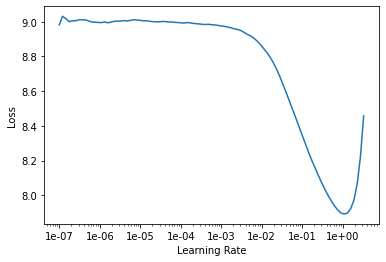

In [ ]:
learn.recorder.plot(skip_start=0)

First step, we do a learning cycle on last layers, then we unfreeze to do fine tuning on all layers, with a lower LR.

In [ ]:
learn.fit_one_cycle(1, 1e-2)

learn.save('head_pretrained')

learn.unfreeze()
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

learn.save('lm_fine_tuned')
learn.save_encoder('ft_enc')
learn.export('language_mode.pkl')

epoch,train_loss,valid_loss,accuracy,time
0,6.809727,5.922798,0.128013,11:28


epoch,train_loss,valid_loss,accuracy,time
0,5.860561,5.501940,0.171596,16:47
1,5.656154,5.406980,0.176172,16:50


# Test

In [ ]:
TEXT = 'ciao'
N_WORDS = 8
N_SENTENCES = 7

In [ ]:
print('\n\n'.join(learn.predict(TEXT,N_WORDS) for _ in range(N_SENTENCES)))

ciao vi fabbrica se me drive un viso ?

ciao li apprezzo probabilmente mi ha detto di sia

ciao griffin salve che ti sei fare uno tu

ciao della loro e darti che dicono chiameremo a

ciao m vecchia xxbos mio tutto sparato signore con

ciao un parenti a alla proteggere quella chiesto spera

ciao fa le uccidi posso io carcere a casa


# Classification task

Now, we have a LM fine-tuned to our target corpus.
The next step is to add layers on top of our LM to do a classification task. 
With fast.ai, it is very easy at it's done automatically.
So in the end we can generate and classify sentences in a way to generate new datasets. 
(Look to the Test section)

In [ ]:
data_clas = TextClasDataBunch.from_df(DATA_PATH, trn_df, val_df, label_cols='label', text_cols='text', tokenizer=Tokenizer(lang = 'it'), bs=48)

In [ ]:
config = awd_lstm_clas_config.copy()
config['n_hid'] = 1150
data_clas.vocab.itos = data_lm.vocab.itos
learn = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.5)

In [ ]:
learn.load_encoder('ft_enc')
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


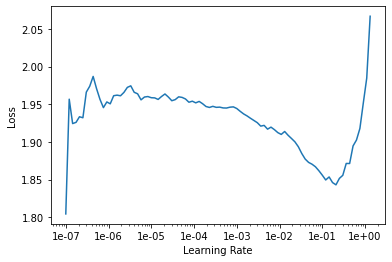

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_start=0)

In [ ]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(7192, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(7192, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, ep

In [ ]:
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.560688,1.493321,0.412295,03:19
1,1.522180,1.462346,0.431373,03:23


In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.505770,1.451927,0.427663,03:57


In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.458052,1.418891,0.453630,06:16


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.398848,1.408081,0.459989,10:10
1,1.370300,1.399984,0.462109,10:59


In [ ]:
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.332749,1.402315,0.456810,10:23
1,1.318777,1.393626,0.471648,10:09


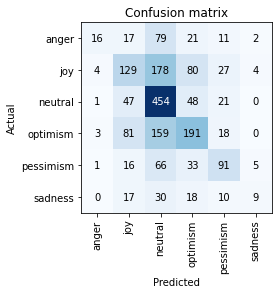

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

In [ ]:
learn.save('class-sub')
learn.export('classifier.pkl')

#Test

In [ ]:
test_text = "ho cenato bene, è stata una bellla serata"
#txt_ci.show_intrinsic_attention(test_text2, cmap = cm.Purples)
learn.predict(test_text)

(Category tensor(2),
 tensor(2),
 tensor([0.0242, 0.2146, 0.3408, 0.1443, 0.0991, 0.1770]))

In [ ]:
test_text2 = "Penso di potercela fare"
#txt_ci.show_intrinsic_attention(test_text2, cmap = cm.Purples)
learn.predict(test_text2)

(Category tensor(3),
 tensor(3),
 tensor([0.0867, 0.2110, 0.1565, 0.4694, 0.0677, 0.0088]))